In [1]:
# Exploratory Data Analysis: Prepared Images
# This notebook explores the image dataset for ankle alignment classification

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Define color scheme for ankle alignment categories
LABEL_COLORS = {
    'Pronation': '#e74c3c',   # Red
    'Neutral': '#3498db',     # Blue
    'Supination': '#2ecc71',  # Green
    'Unlabeled': '#95a5a6'    # Gray
}

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load Dataset

Load the prepared images and their labels from the merged CSV file.


In [2]:
# Define paths
DATA_PATH = Path("../data")
IMAGE_PATH = DATA_PATH / "prepared_images"
LABELS_PATH = DATA_PATH / "labels"

# Load labels
df = pd.read_csv(LABELS_PATH / "merged_labels.csv")

# Add full image path
df['image_path'] = df['filename'].apply(lambda x: IMAGE_PATH / x)

# Check which images actually exist
df['exists'] = df['image_path'].apply(lambda x: x.exists())

print(f"Total entries in labels CSV: {len(df)}")
print(f"Images that exist: {df['exists'].sum()}")
print(f"Missing images: {(~df['exists']).sum()}")

# Filter to only existing images
df = df[df['exists']].copy()
print(f"\nWorking with {len(df)} images")


Total entries in labels CSV: 326
Images that exist: 326
Missing images: 0

Working with 326 images


In [3]:
# Display sample of the data
print("Dataset Info:")
print(f"  Columns: {list(df.columns)}")
print(f"  Shape: {df.shape}")
print("\nFirst 10 entries:")
df[['filename', 'original_filename', 'label']].head(10)


Dataset Info:
  Columns: ['filename', 'original_filename', 'label', 'image_path', 'exists']
  Shape: (326, 5)

First 10 entries:


filename             original_filename  \
0      B8V41Y_internet_actualne_01.png      internet_actualne_01.jpg   
1        B8V41Y_internet_algeos_01.png        internet_algeos_01.jpg   
2    B8V41Y_internet_everypixel_01.png    internet_everypixel_01.jpg   
3      B8V41Y_internet_facebook_01.png      internet_facebook_01.jpg   
4       B8V41Y_internet_freepic_02.png       internet_freepic_02.jpg   
5       B8V41Y_internet_freepic_03.png       internet_freepic_03.jpg   
6       B8V41Y_internet_freepik_01.png       internet_freepik_01.jpg   
7  B8V41Y_internet_learnmuscles_01.png  internet_learnmuscles_01.jpg   
8  B8V41Y_internet_shutterstock_01.png  internet_shutterstock_01.jpg   
9  B8V41Y_internet_shutterstock_02.png  internet_shutterstock_02.jpg   

       label  
0  Pronation  
1    Neutral  
2  Pronation  
3  Pronation  
4  Pronation  
5    Neutral  
6    Neutral  
7  Pronation  
8    Neutral  
9    Neutral

## 2. Label Distribution Analysis

Analyze the distribution of ankle alignment categories in the dataset.


In [4]:
# Calculate label distribution
label_counts = df['label'].value_counts()
label_pcts = df['label'].value_counts(normalize=True) * 100

print("Label Distribution:")
print("=" * 40)
for label in label_counts.index:
    print(f"  {label}: {label_counts[label]:>4} images ({label_pcts[label]:.1f}%)")
print(f"\n  Total: {len(df)} images")


Label Distribution:
  Neutral:  140 images (42.9%)
  Pronation:  133 images (40.8%)
  Supination:   50 images (15.3%)
  Unlabeled:    3 images (0.9%)

  Total: 326 images


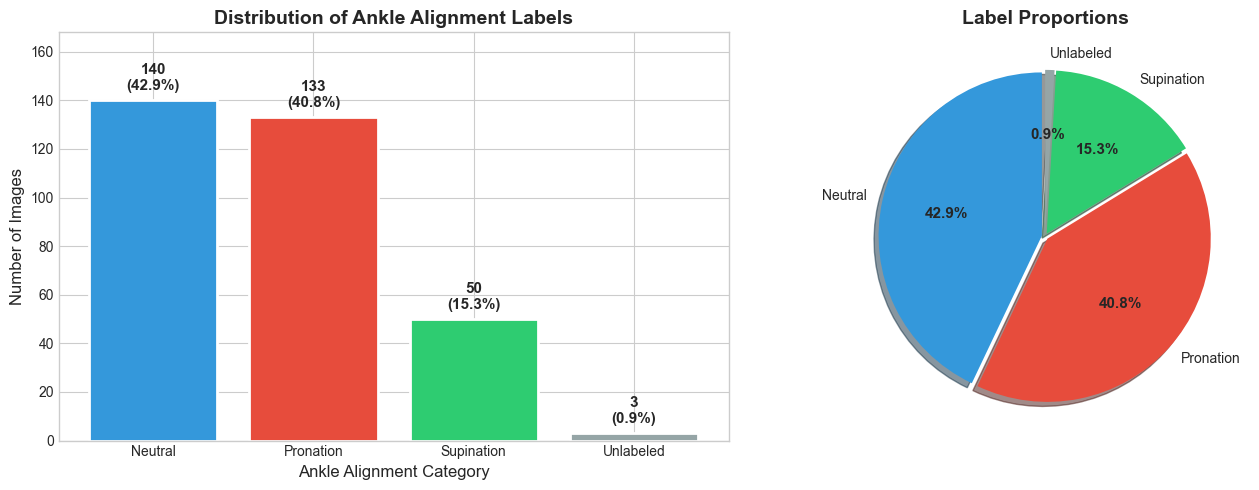

In [5]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
colors = [LABEL_COLORS.get(label, '#95a5a6') for label in label_counts.index]
bars = ax1.bar(label_counts.index, label_counts.values, color=colors, edgecolor='white', linewidth=2)
ax1.set_xlabel('Ankle Alignment Category', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Distribution of Ankle Alignment Labels', fontsize=14, fontweight='bold')

# Add count labels on bars
for bar, count, pct in zip(bars, label_counts.values, label_pcts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylim(0, max(label_counts.values) * 1.2)

# Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(label_counts.values, labels=label_counts.index,
                                    colors=colors, autopct='%1.1f%%',
                                    explode=[0.02] * len(label_counts),
                                    shadow=True, startangle=90)
ax2.set_title('Label Proportions', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()


In [6]:
# Class imbalance analysis
majority_class = label_counts.index[0]
minority_class = label_counts.index[-1]
imbalance_ratio = label_counts.max() / label_counts.min()

print("Class Imbalance Analysis:")
print("=" * 50)
print(f"  Majority class: {majority_class} ({label_counts.max()} samples)")
print(f"  Minority class: {minority_class} ({label_counts.min()} samples)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("\n  ⚠️ Significant class imbalance detected!")
    print("  Consider: oversampling, undersampling, or class weights during training")
elif imbalance_ratio > 1.5:
    print("\n  ℹ️ Moderate class imbalance present")
    print("  Consider: stratified sampling for train/val/test splits")
else:
    print("\n  ✓ Classes are relatively balanced")


Class Imbalance Analysis:
  Majority class: Neutral (140 samples)
  Minority class: Unlabeled (3 samples)
  Imbalance ratio: 46.67:1

  ⚠️ Significant class imbalance detected!
  Consider: oversampling, undersampling, or class weights during training


## 3. Image Properties Analysis

Analyze image dimensions, aspect ratios, file sizes, and color properties.


In [7]:
def get_image_properties(image_path):
    """Extract properties from an image file."""
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            mode = img.mode
            file_size = image_path.stat().st_size / 1024  # KB
            return {
                'width': width,
                'height': height,
                'aspect_ratio': width / height,
                'pixels': width * height,
                'mode': mode,
                'file_size_kb': file_size
            }
    except Exception as e:
        return None

# Extract properties for all images
print("Extracting image properties...")
properties = []
for idx, row in df.iterrows():
    props = get_image_properties(row['image_path'])
    if props:
        props['filename'] = row['filename']
        props['label'] = row['label']
        properties.append(props)

df_props = pd.DataFrame(properties)
print(f"Successfully analyzed {len(df_props)} images")


Extracting image properties...
Successfully analyzed 326 images


In [8]:
# Summary statistics for image dimensions
print("Image Dimension Statistics:")
print("=" * 60)

stats_cols = ['width', 'height', 'aspect_ratio', 'pixels', 'file_size_kb']
summary = df_props[stats_cols].describe()
summary.loc['range'] = summary.loc['max'] - summary.loc['min']

print(f"\n{'Metric':<20} {'Min':>10} {'Mean':>10} {'Max':>10} {'Std':>10}")
print("-" * 60)
for col in stats_cols:
    print(f"{col:<20} {summary.loc['min', col]:>10.1f} {summary.loc['mean', col]:>10.1f} "
          f"{summary.loc['max', col]:>10.1f} {summary.loc['std', col]:>10.1f}")


Image Dimension Statistics:

Metric                      Min       Mean        Max        Std
------------------------------------------------------------
width                     170.0     1739.4     7172.0     1384.6
height                    148.0     1684.7     4912.0     1414.6
aspect_ratio                0.6        1.2        2.3        0.4
pixels                  33630.0  4669134.1 34325192.0  6101415.3
file_size_kb               22.9     3428.5    32033.5     4846.7


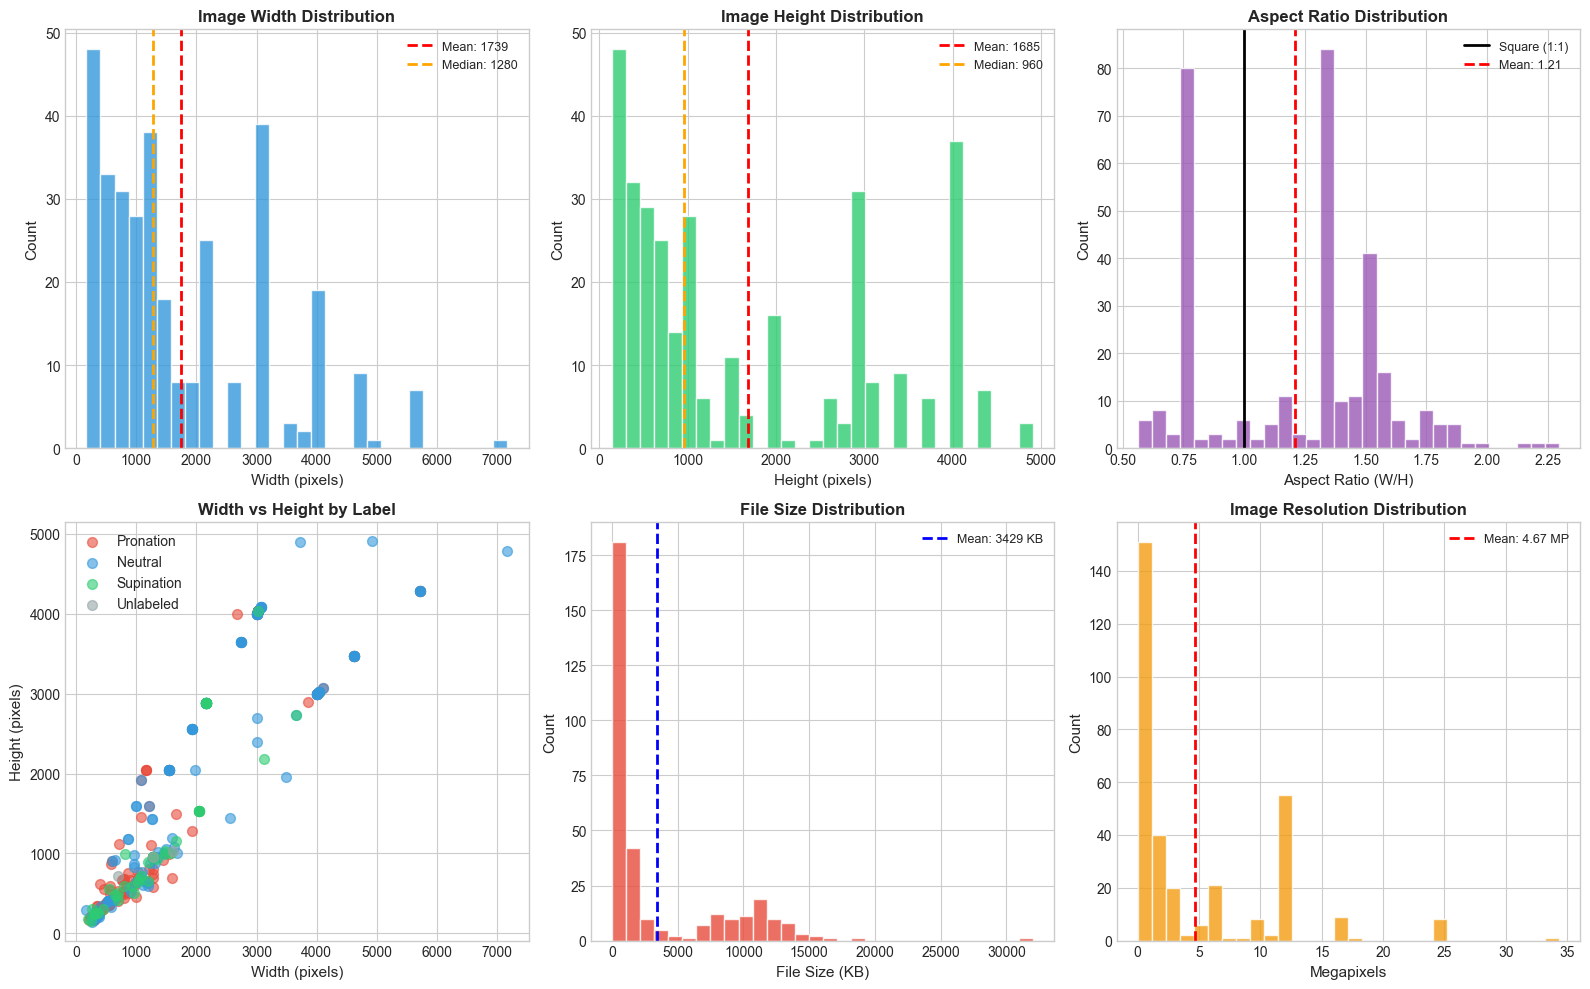

In [9]:
# Visualize dimension distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Width distribution
ax = axes[0, 0]
ax.hist(df_props['width'], bins=30, color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(df_props['width'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_props['width'].mean():.0f}")
ax.axvline(df_props['width'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df_props['width'].median():.0f}")
ax.set_xlabel('Width (pixels)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Image Width Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

# Height distribution
ax = axes[0, 1]
ax.hist(df_props['height'], bins=30, color='#2ecc71', edgecolor='white', alpha=0.8)
ax.axvline(df_props['height'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_props['height'].mean():.0f}")
ax.axvline(df_props['height'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df_props['height'].median():.0f}")
ax.set_xlabel('Height (pixels)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Image Height Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

# Aspect ratio distribution
ax = axes[0, 2]
ax.hist(df_props['aspect_ratio'], bins=30, color='#9b59b6', edgecolor='white', alpha=0.8)
ax.axvline(1.0, color='black', linestyle='-', linewidth=2, label='Square (1:1)')
ax.axvline(df_props['aspect_ratio'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_props['aspect_ratio'].mean():.2f}")
ax.set_xlabel('Aspect Ratio (W/H)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

# Width vs Height scatter
ax = axes[1, 0]
for label in df_props['label'].unique():
    mask = df_props['label'] == label
    ax.scatter(df_props.loc[mask, 'width'], df_props.loc[mask, 'height'], 
               c=LABEL_COLORS.get(label, '#95a5a6'), label=label, alpha=0.6, s=50)
ax.set_xlabel('Width (pixels)', fontsize=11)
ax.set_ylabel('Height (pixels)', fontsize=11)
ax.set_title('Width vs Height by Label', fontsize=12, fontweight='bold')
ax.legend()

# File size distribution
ax = axes[1, 1]
ax.hist(df_props['file_size_kb'], bins=30, color='#e74c3c', edgecolor='white', alpha=0.8)
ax.axvline(df_props['file_size_kb'].mean(), color='blue', linestyle='--', linewidth=2, label=f"Mean: {df_props['file_size_kb'].mean():.0f} KB")
ax.set_xlabel('File Size (KB)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('File Size Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

# Pixel count distribution
ax = axes[1, 2]
megapixels = df_props['pixels'] / 1_000_000
ax.hist(megapixels, bins=30, color='#f39c12', edgecolor='white', alpha=0.8)
ax.axvline(megapixels.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {megapixels.mean():.2f} MP")
ax.set_xlabel('Megapixels', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Image Resolution Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


we can see a clear split in resolution between camera pics and images taken from the web. Interesting!

In [10]:
# Image properties by class
print("Image Properties by Class:")
print("=" * 70)

stats_by_class = df_props.groupby('label')[['width', 'height', 'aspect_ratio', 'file_size_kb']].agg(['mean', 'std', 'min', 'max'])

for label in df_props['label'].unique():
    if pd.isna(label):
        continue
    subset = df_props[df_props['label'] == label]
    print(f"\n{label} ({len(subset)} images):")
    print(f"  Width:        {subset['width'].mean():.0f} ± {subset['width'].std():.0f} px (range: {subset['width'].min()}-{subset['width'].max()})")
    print(f"  Height:       {subset['height'].mean():.0f} ± {subset['height'].std():.0f} px (range: {subset['height'].min()}-{subset['height'].max()})")
    print(f"  Aspect Ratio: {subset['aspect_ratio'].mean():.2f} ± {subset['aspect_ratio'].std():.2f}")
    print(f"  File Size:    {subset['file_size_kb'].mean():.0f} ± {subset['file_size_kb'].std():.0f} KB")


Image Properties by Class:

Pronation (133 images):
  Width:        1472 ± 1351 px (range: 220-5712)
  Height:       1416 ± 1435 px (range: 165-4284)
  Aspect Ratio: 1.26 ± 0.37
  File Size:    3137 ± 4831 KB

Neutral (140 images):
  Width:        2123 ± 1504 px (range: 170-7172)
  Height:       2095 ± 1437 px (range: 148-4912)
  Aspect Ratio: 1.15 ± 0.37
  File Size:    4476 ± 5351 KB

Supination (50 images):
  Width:        1408 ± 795 px (range: 190-3648)
  Height:       1295 ± 1000 px (range: 152-4032)
  Aspect Ratio: 1.26 ± 0.32
  File Size:    1431 ± 1950 KB

Unlabeled (3 images):
  Width:        1197 ± 460 px (range: 701-1609)
  Height:       904 ± 161 px (range: 722-1030)
  Aspect Ratio: 1.29 ± 0.30
  File Size:    756 ± 294 KB


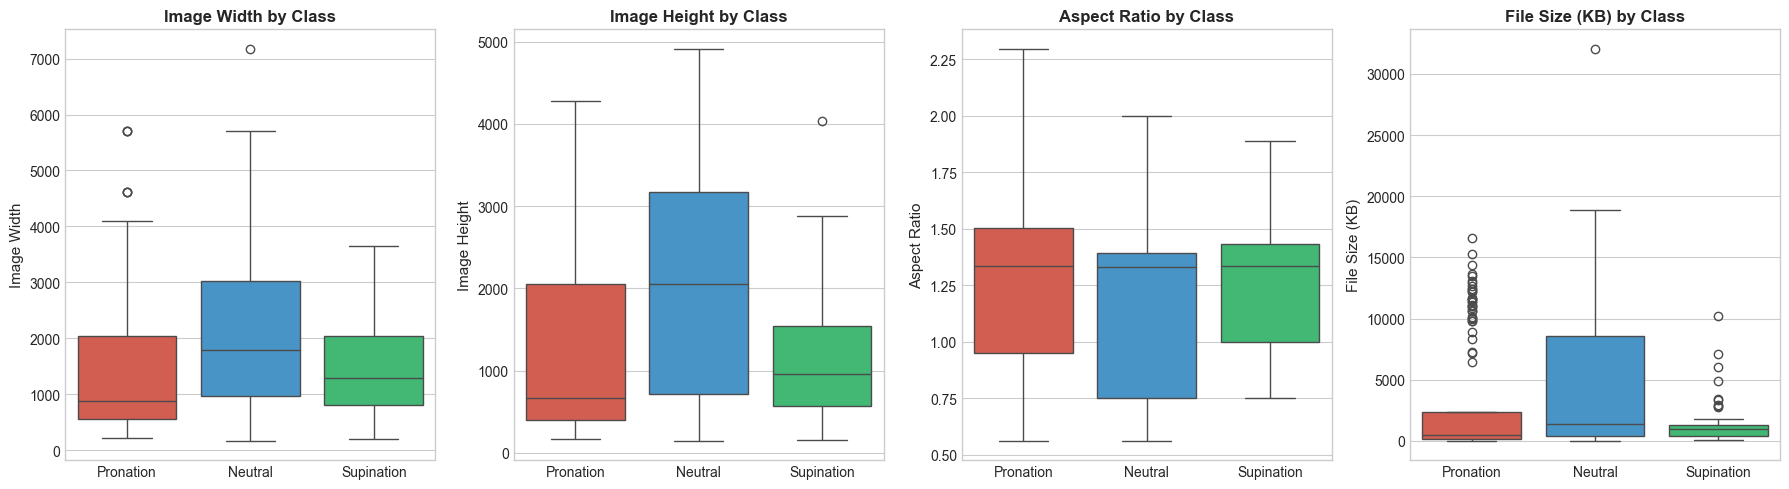

In [11]:
# Box plots comparing properties across classes
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

properties_to_plot = ['width', 'height', 'aspect_ratio', 'file_size_kb']
titles = ['Image Width', 'Image Height', 'Aspect Ratio', 'File Size (KB)']

for ax, prop, title in zip(axes, properties_to_plot, titles):
    # Create ordered categories for consistent coloring
    order = ['Pronation', 'Neutral', 'Supination']
    order = [o for o in order if o in df_props['label'].values]
    
    palette = {label: LABEL_COLORS.get(label, '#95a5a6') for label in order}
    
    sns.boxplot(data=df_props, x='label', y=prop, order=order, palette=palette, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} by Class', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 4. Sample Image Visualization

Display random sample images from each ankle alignment category.


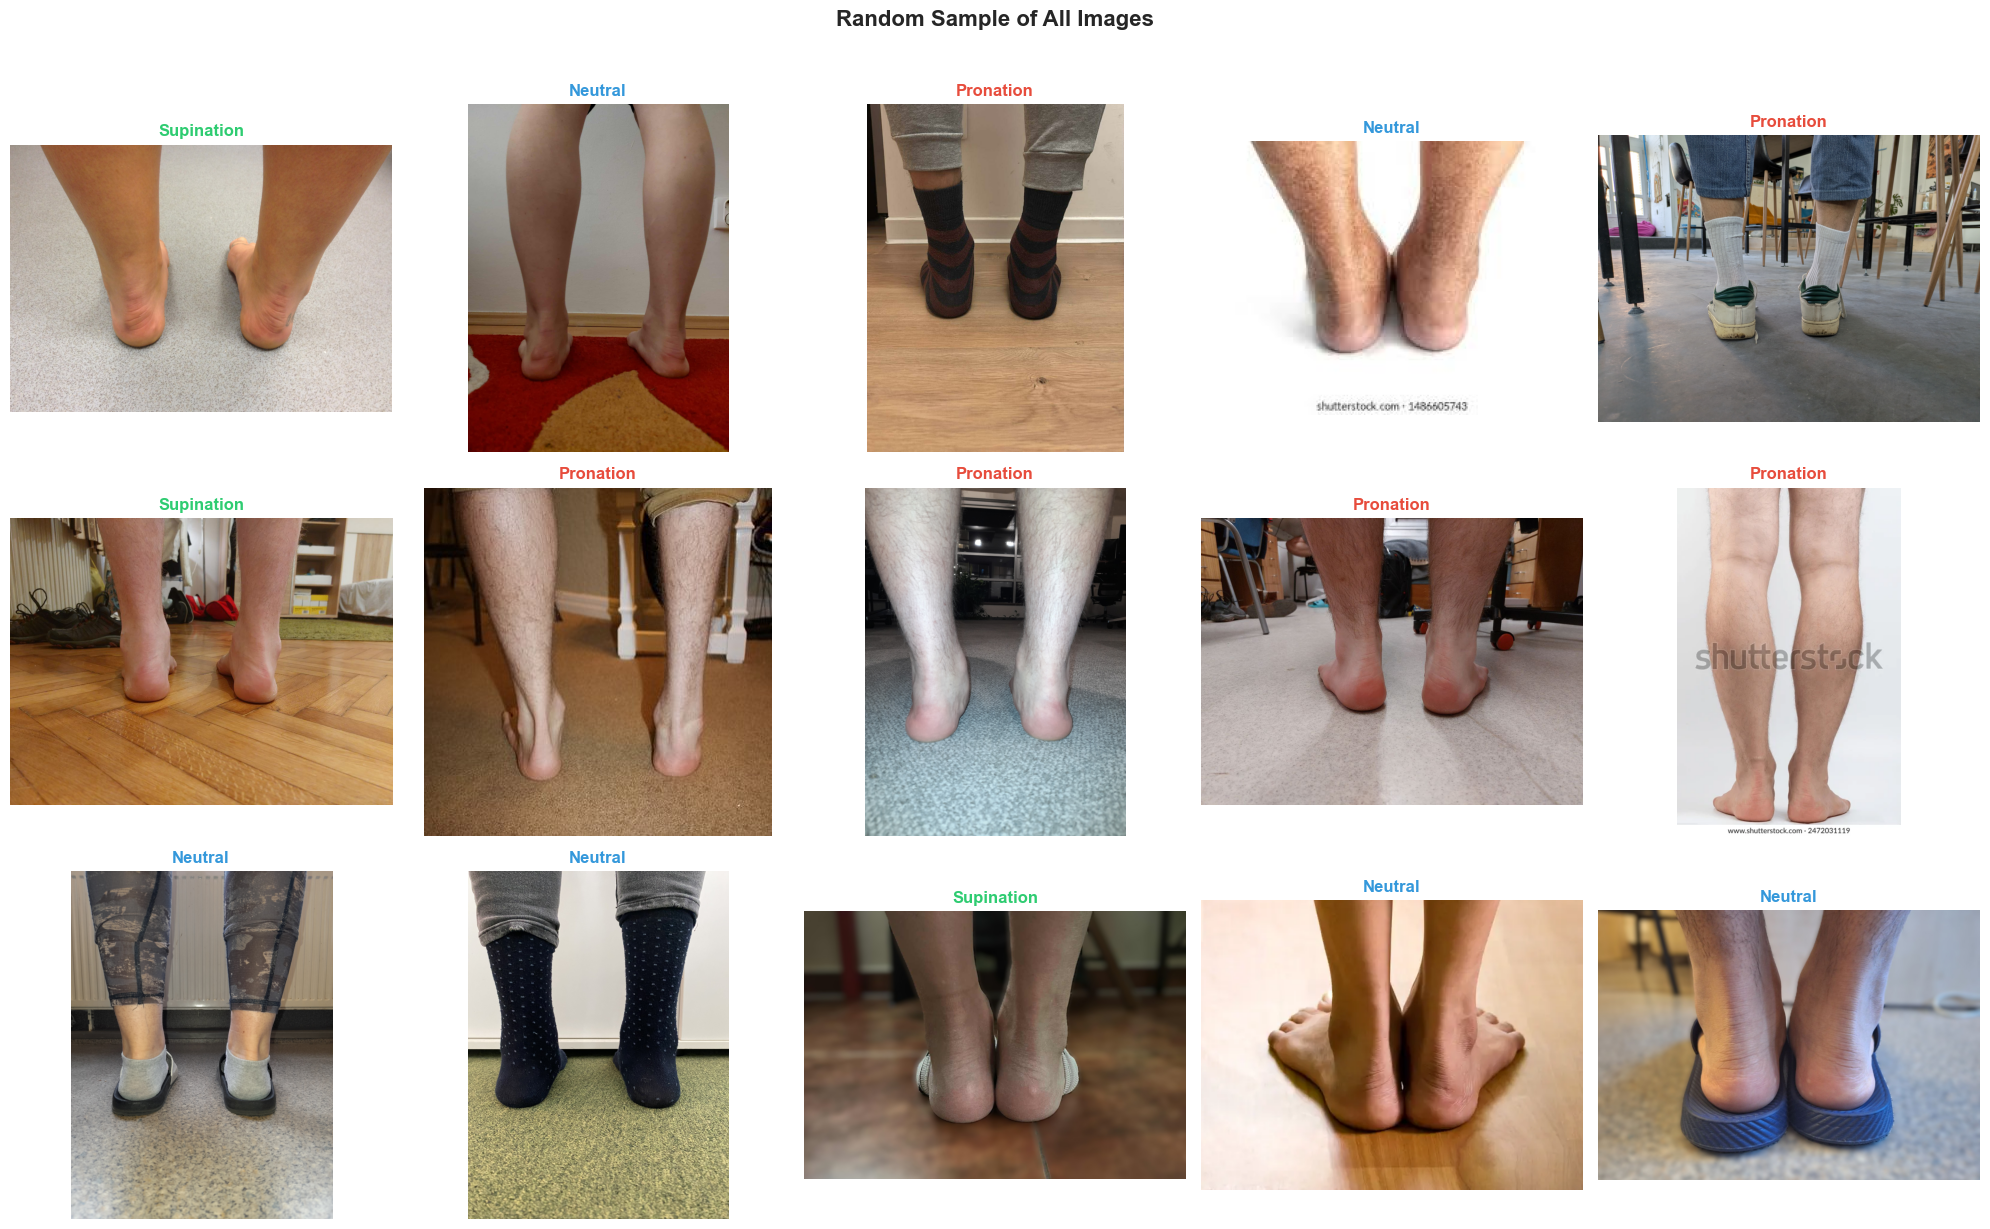

In [12]:
def show_image_grid(df, n_rows=3, n_cols=4, title="Sample Images", random_seed=42):
    """Display a grid of sample images."""
    np.random.seed(random_seed)
    
    n_images = n_rows * n_cols
    sample = df.sample(min(n_images, len(df)))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
    
    for idx, (ax, (_, row)) in enumerate(zip(axes, sample.iterrows())):
        try:
            img = Image.open(row['image_path'])
            ax.imshow(img)
            label_color = LABEL_COLORS.get(row['label'], 'black')
            ax.set_title(f"{row['label']}", fontsize=12, fontweight='bold', color=label_color)
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading\n{row['filename']}", ha='center', va='center')
            ax.axis('off')
    
    # Hide unused axes
    for ax in axes[len(sample):]:
        ax.axis('off')
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Show random sample of all images
show_image_grid(df, n_rows=3, n_cols=5, title="Random Sample of All Images")


some questionable labels

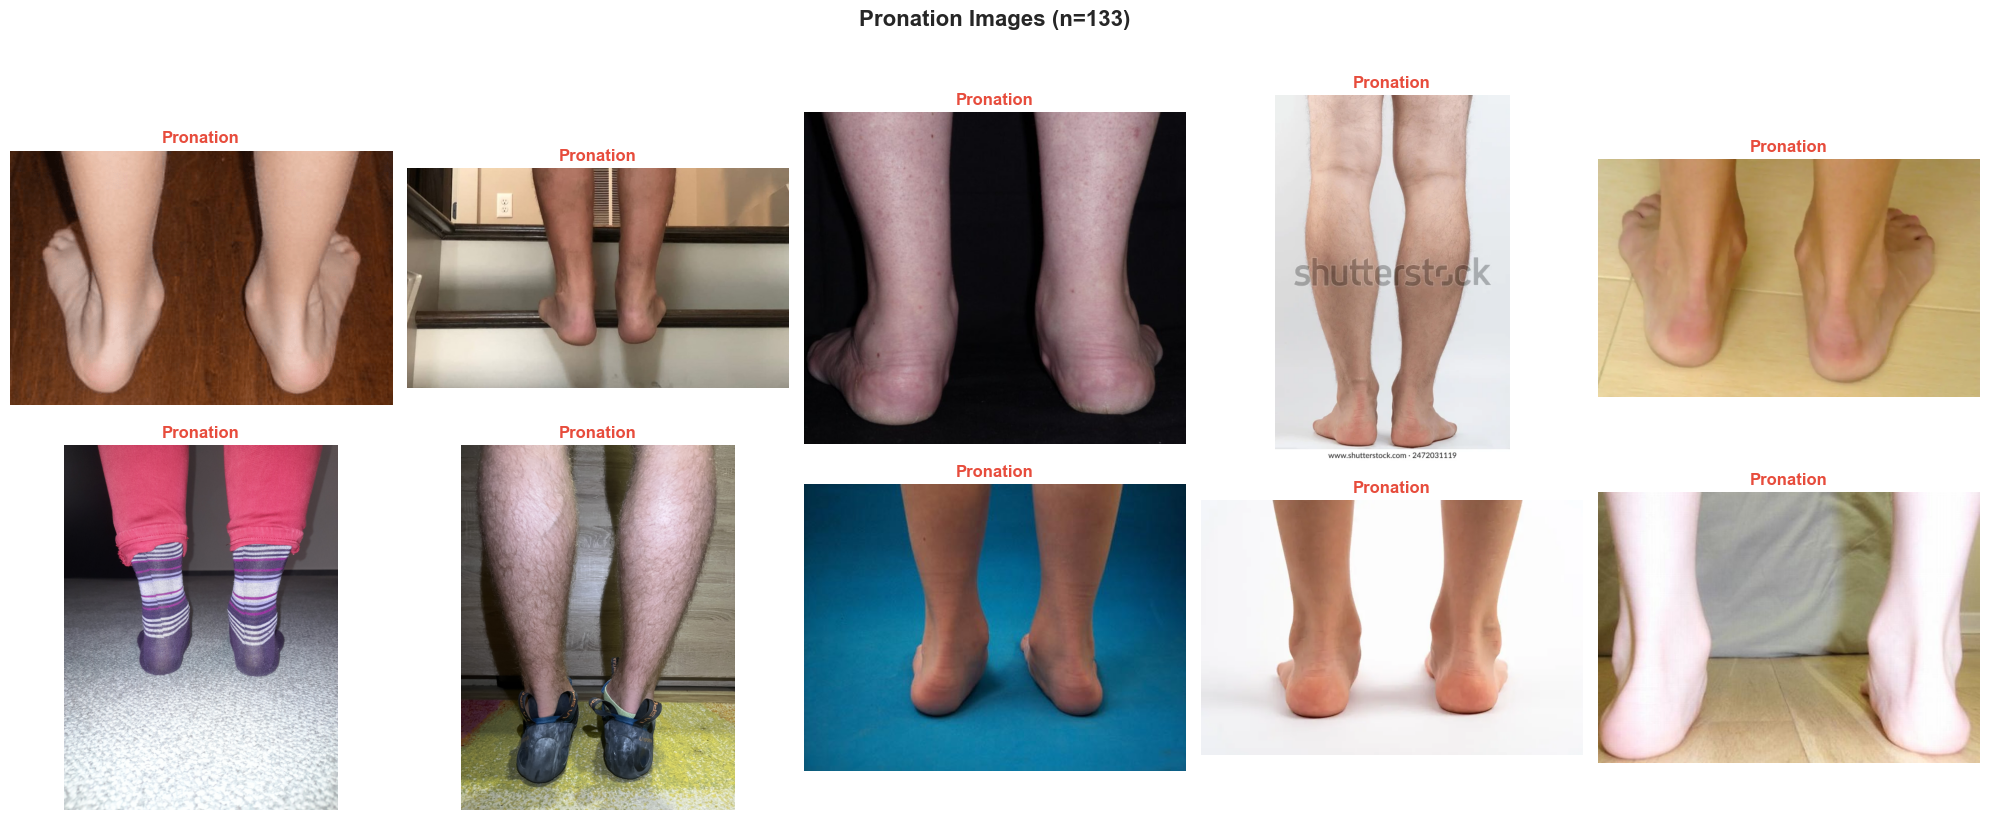

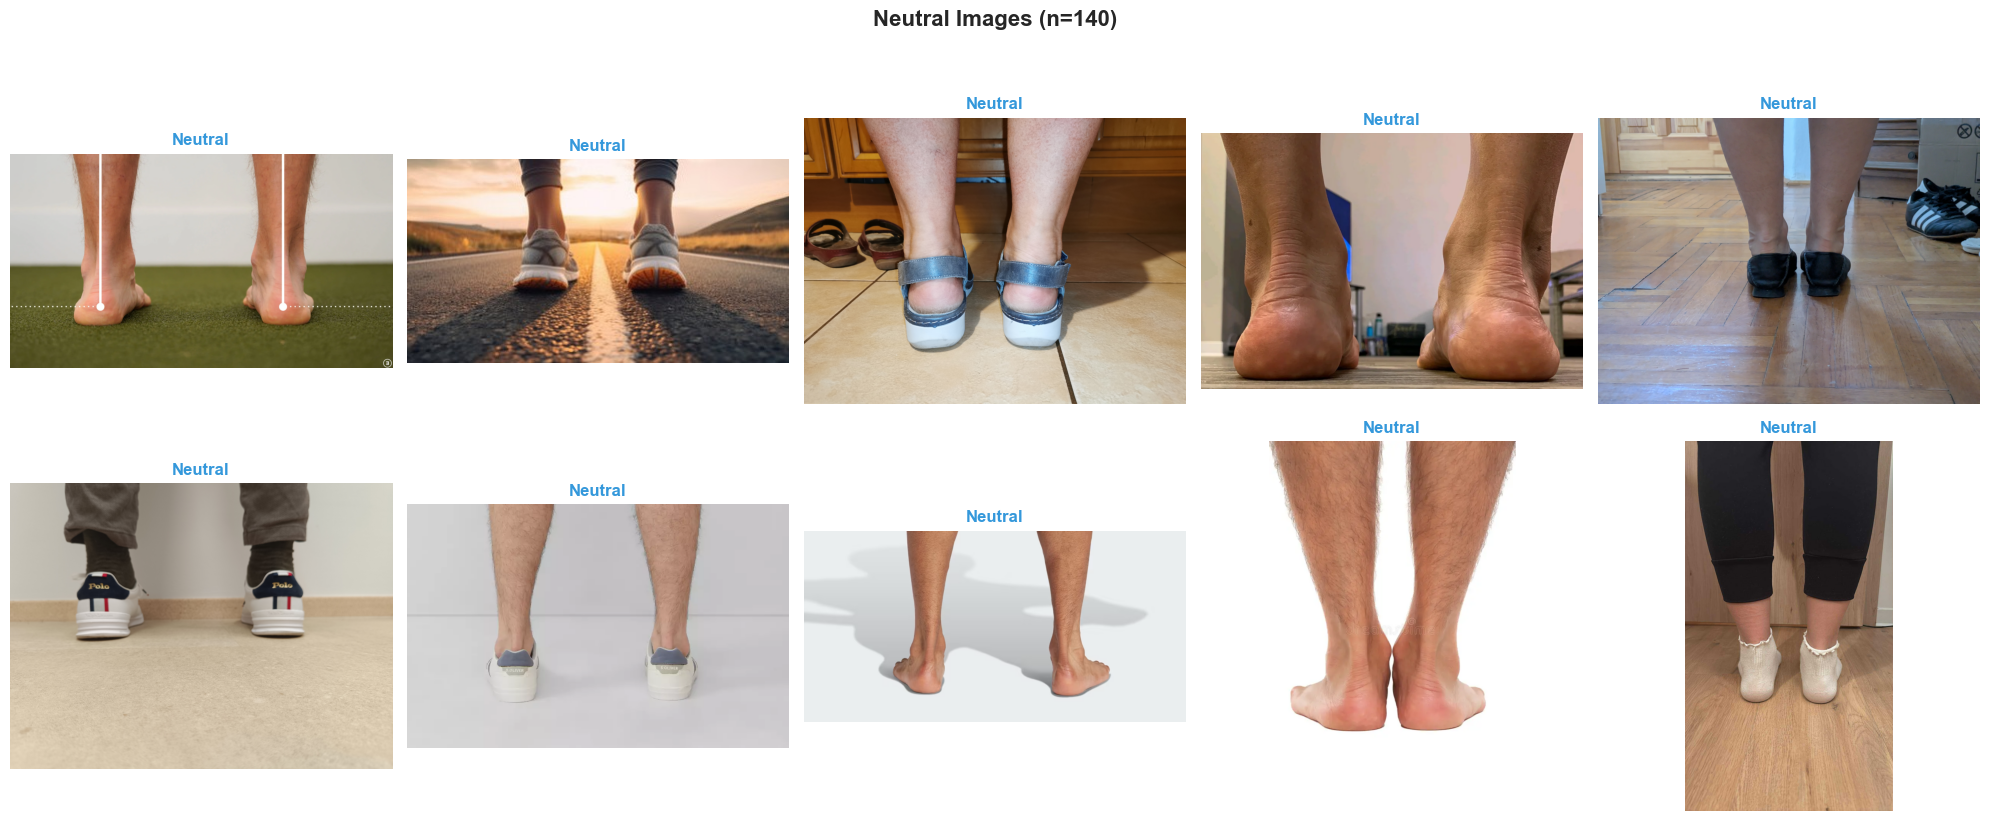

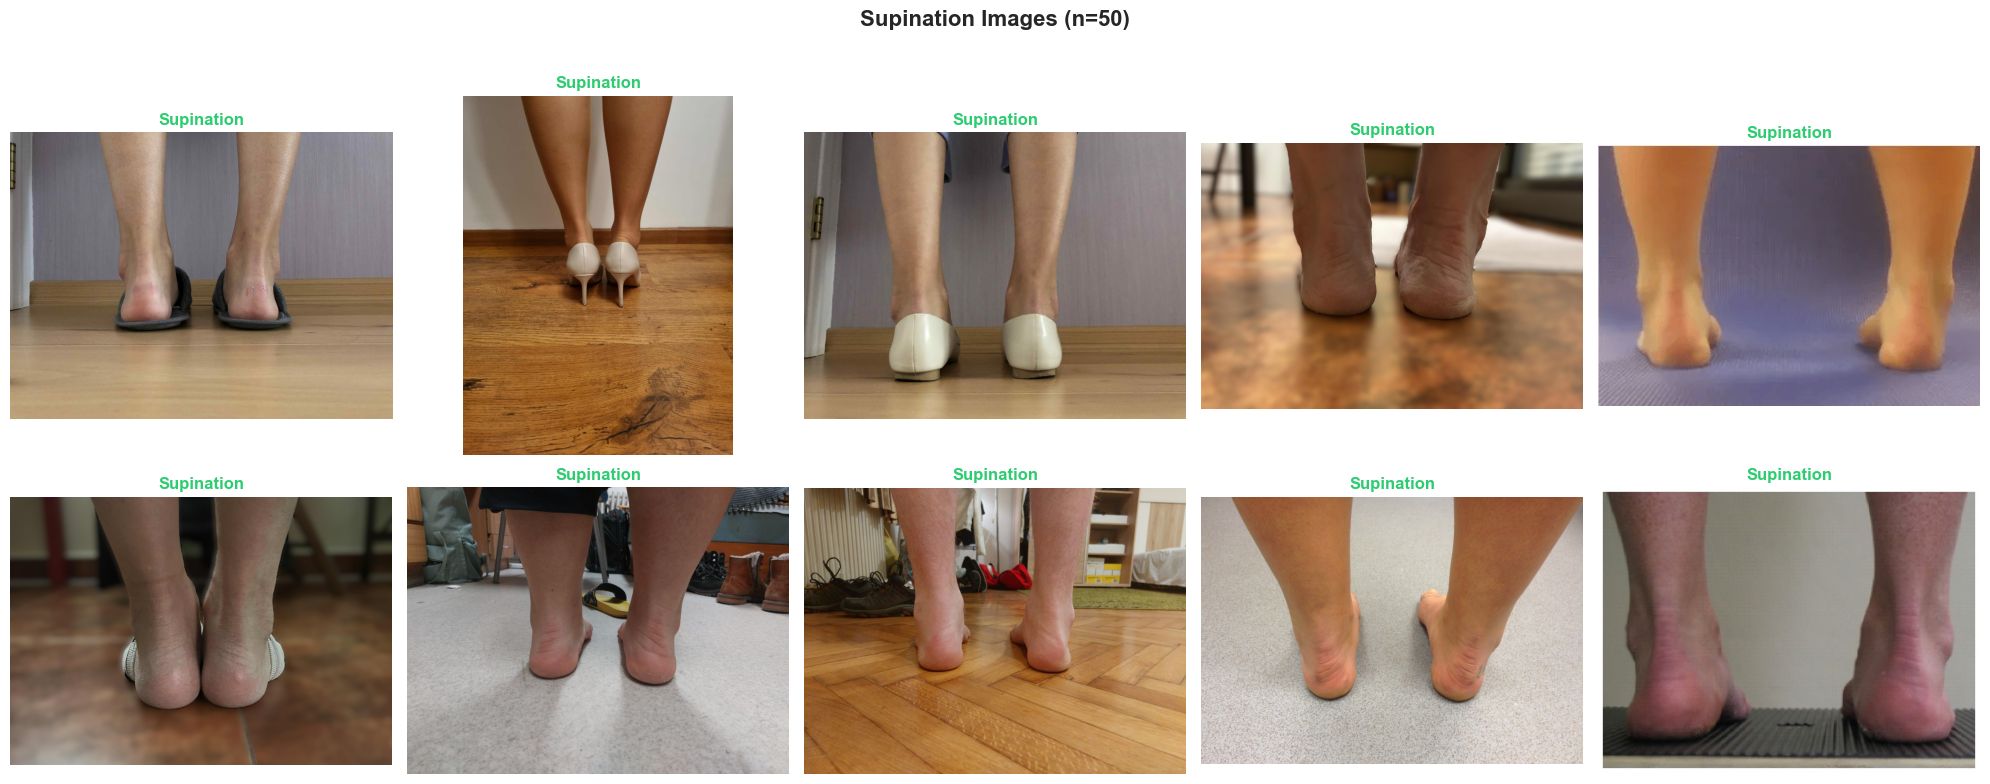

In [13]:
# Show samples by class
for label in ['Pronation', 'Neutral', 'Supination']:
    label_df = df[df['label'] == label]
    if len(label_df) > 0:
        n_show = min(10, len(label_df))
        n_cols = min(5, n_show)
        n_rows = (n_show + n_cols - 1) // n_cols
        show_image_grid(label_df, n_rows=n_rows, n_cols=n_cols, 
                       title=f"{label} Images (n={len(label_df)})",
                       random_seed=42)


## 6. Data Source Analysis

Analyze the distribution of images by source (labeler ID) and origin type.


In [14]:
# Extract labeler ID from filename (first part before underscore)
df['labeler_id'] = df['filename'].apply(lambda x: x.split('_')[0])

# Determine if image is from internet or own (sajat) photos
df['source_type'] = df['original_filename'].apply(
    lambda x: 'Own Photos' if 'sajat' in x.lower() or 'resztvevo' in x.lower() else 'Internet'
)

print("Images by Labeler ID:")
labeler_counts = df['labeler_id'].value_counts()
print(labeler_counts)

print(f"\n\nImages by Source Type:")
print(df['source_type'].value_counts())


Images by Labeler ID:
labeler_id
GK1XQ4    52
C6037J    34
FO6K58    32
H51B9J    23
ITWQ3V    23
D6AE9F    22
B8V41Y    20
FGWUFP    20
NC1O2T    20
NX9GA4    20
ODZF0M    20
OJHGS8    20
XV0M8Z    20
Name: count, dtype: int64


Images by Source Type:
source_type
Own Photos    177
Internet      149
Name: count, dtype: int64


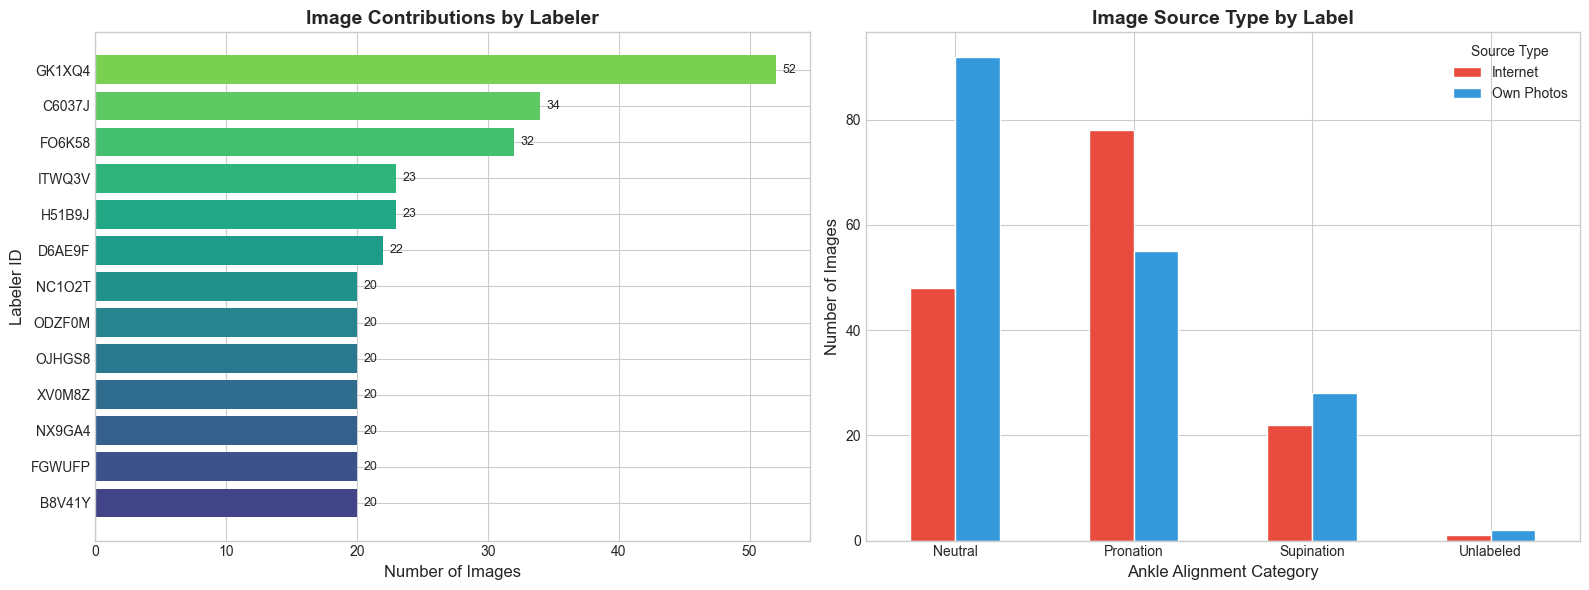

In [15]:
# Visualize labeler contributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Images per labeler
ax1 = axes[0]
labeler_counts_sorted = labeler_counts.sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(labeler_counts_sorted)))
bars = ax1.barh(range(len(labeler_counts_sorted)), labeler_counts_sorted.values, color=colors)
ax1.set_yticks(range(len(labeler_counts_sorted)))
ax1.set_yticklabels(labeler_counts_sorted.index)
ax1.set_xlabel('Number of Images', fontsize=12)
ax1.set_ylabel('Labeler ID', fontsize=12)
ax1.set_title('Image Contributions by Labeler', fontsize=14, fontweight='bold')

# Add count labels
for bar, count in zip(bars, labeler_counts_sorted.values):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             str(count), va='center', fontsize=9)

# Source type breakdown by label
ax2 = axes[1]
source_by_label = df.groupby(['label', 'source_type']).size().unstack(fill_value=0)
source_by_label.plot(kind='bar', ax=ax2, color=['#e74c3c', '#3498db'], edgecolor='white')
ax2.set_xlabel('Ankle Alignment Category', fontsize=12)
ax2.set_ylabel('Number of Images', fontsize=12)
ax2.set_title('Image Source Type by Label', fontsize=14, fontweight='bold')
ax2.legend(title='Source Type', fontsize=10)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


In [16]:
# Label distribution by labeler
print("Label Distribution by Labeler:")
print("=" * 70)

labeler_label_dist = df.groupby(['labeler_id', 'label']).size().unstack(fill_value=0)
labeler_label_dist['Total'] = labeler_label_dist.sum(axis=1)
labeler_label_dist = labeler_label_dist.sort_values('Total', ascending=False)
labeler_label_dist


Label Distribution by Labeler:


label       Neutral  Pronation  Supination  Unlabeled  Total
labeler_id                                                  
GK1XQ4           17         28           7          0     52
C6037J           13         16           5          0     34
FO6K58           17          7           8          0     32
H51B9J           15          8           0          0     23
ITWQ3V            4         11           7          1     23
D6AE9F           11          7           4          0     22
B8V41Y           13          7           0          0     20
FGWUFP           12          8           0          0     20
NC1O2T            7          8           5          0     20
NX9GA4           10         10           0          0     20
ODZF0M            6         11           2          1     20
OJHGS8            4          9           7          0     20
XV0M8Z           11          3           5          1     20

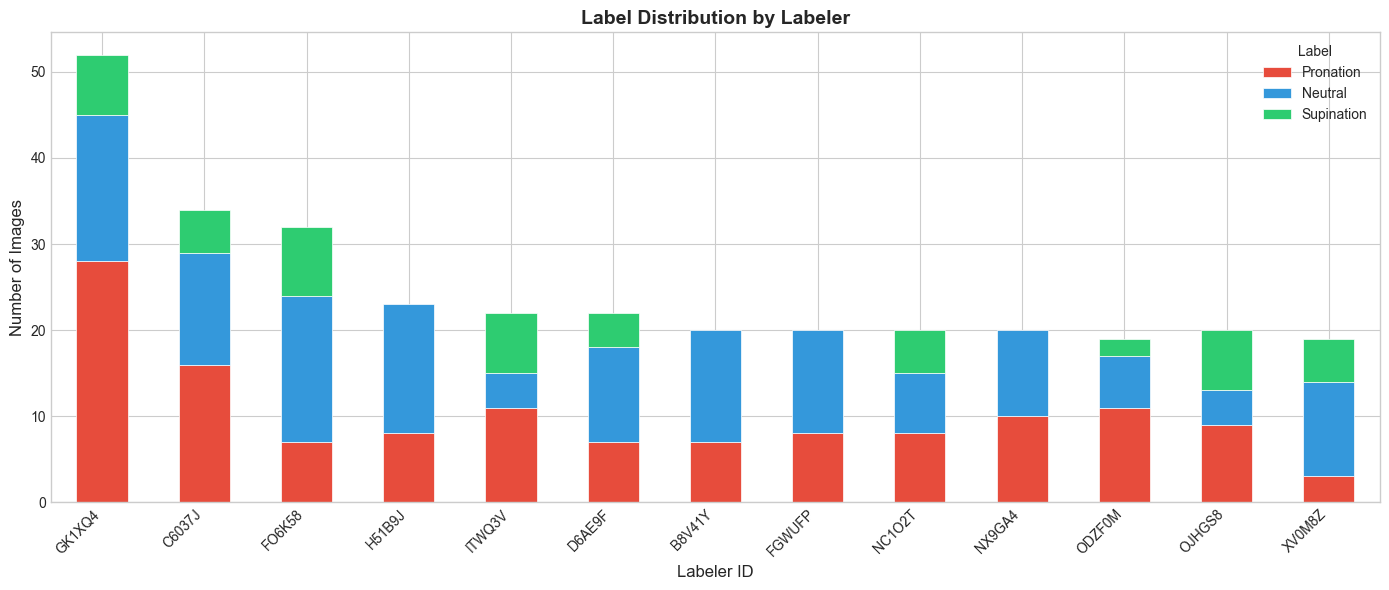

In [17]:
# Stacked bar chart of labels by labeler
fig, ax = plt.subplots(figsize=(14, 6))

labeler_label_dist_plot = labeler_label_dist.copy()
if 'Total' in labeler_label_dist_plot.columns:
    labeler_label_dist_plot = labeler_label_dist_plot.drop(columns='Total')

# Reorder columns for consistent stacking
cols_order = ['Pronation', 'Neutral', 'Supination']
cols_order = [c for c in cols_order if c in labeler_label_dist_plot.columns]
labeler_label_dist_plot = labeler_label_dist_plot[cols_order]

labeler_label_dist_plot.plot(kind='bar', stacked=True, ax=ax, 
                              color=[LABEL_COLORS.get(c, '#95a5a6') for c in cols_order],
                              edgecolor='white', linewidth=0.5)
ax.set_xlabel('Labeler ID', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Label Distribution by Labeler', fontsize=14, fontweight='bold')
ax.legend(title='Label', loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [18]:
# save df_props
df_props.to_csv(DATA_PATH / "image_properties.csv", index=False)